# Naive Bayes (the easy way)

We'll cheat by using sklearn.naive_bayes to train a spam classifier! Most of the code is just loading our training data into a pandas DataFrame that we can play with:

In [1]:
### Standard library ###
# import random
# import math
import time
#import tqdm
import os
import io

### Third-party libraries ### 
import numpy
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

---
### Funções utilizadas pelo programa.

In [2]:
def readFiles(path):
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            path = os.path.join(root, filename)

            inBody = False
            lines = []
            f = io.open(path, 'r', encoding='latin1')
            for line in f:
                if inBody:
                    lines.append(line)
                elif line == '\n':
                    inBody = True
            f.close()
            message = '\n'.join(lines)
            yield path, message


def dataFrameFromDirectory(path, classification):
    rows = []
    index = []
    for filename, message in readFiles(path):
        rows.append({'message': message, 'class': classification})
        index.append(filename)

    return DataFrame(rows, index=index)

In [3]:
# Tic
sys_start_time = time.perf_counter()

---
# 1. Loading data

In [4]:
data = DataFrame({'message': [], 'class': []})

data = data.append(dataFrameFromDirectory('emails/spam', 'spam'))
data = data.append(dataFrameFromDirectory('emails/ham', 'ham'))

---
# 2. EDA

Let's have a look at that DataFrame:

In [5]:
print('* Amostra da base:')
data.sample(4)

* Amostra da base:


,message,class
emails/ham/00603.712b15c7b1e7bef7235068a3e4d9bd39,">>>>> ""J"" == Justin Mason <jm@jmason.org> writ...",ham
emails/ham/01961.b47390d07cd4c2dba35176e9a948bac4,URL: http://jeremy.zawodny.com/blog/archives/0...,ham
emails/ham/02098.96a584164de1918fe146c1ef4012182e,"URL: http://www.newsisfree.com/click/-1,839972...",ham
emails/spam/00147.1782d51354c31ea53db25ea927d5c51d,<HTML><HEAD><TITLE>Big and big</TITLE>\n\n<MET...,spam


In [6]:
data.index[0]

'emails/spam/00467.5b733c506b7165424a0d4a298e67970f'

In [7]:
data.iloc[0,0]

'This is a multipart MIME message.\n\n\n\n--= Multipart Boundary 0925021429\n\nContent-Type: text/plain;\n\n\tcharset="ISO-8859-1"\n\nContent-Transfer-Encoding: 8bit\n\n\n\n<html>\n\n\n\n<head>\n\n</head>\n\n\n\n<body>\n\n\n\n<p align="center"><span style="font-size:7.5pt;font-family:Arial;color:black">You\n\nare receiving this email because you opted-in to receive special offers from\n\nOptinDeals through one of our marketing partners. If you feel you have received\n\nthis email in error or do not wish to receive additional special offers, please\n\nreply to this email with the word &quot;remove&quot; in the subject line or\n\nfollow the unsubscribe instructions below.<o:p>\n\n</o:p>\n\n</span></p>\n\n<p><a href="http://www.inkjetrus.com/customer!.html"><img border="0" \n\nsrc="http://www.inkjetrus.com/clip%20art/toper.jpg" width="800" height="100"></a>\n\n</p>\n\n<div align="center">\n\n  <strong><font face="Arial" size="6">Incredible Deals on Inkjet Cartridges!\n\n</font></strong>\n

In [8]:
df_size = data.shape
print('* Tamanho da base: %d linhas x %d colunas' % (df_size[0],df_size[1]))

* Tamanho da base: 3000 linhas x 2 colunas


In [9]:
print('* Numero de elementos distintos de cada coluna:')
data.nunique()

* Numero de elementos distintos de cada coluna:


message    2943
class         2
dtype: int64

In [10]:
print('* Verificando campos não preenchidos:')
data.isna().sum()

* Verificando campos não preenchidos:


message    0
class      0
dtype: int64

In [11]:
print('* Tipos de valores da base:')
data.dtypes

* Tipos de valores da base:


message    object
class      object
dtype: object

Fração de spam: 16.7% 
Fração de ham: 83.3% 


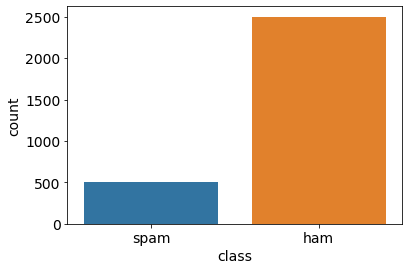

In [12]:
### Verificando o balanço entre as classes (Classificador apenas!!): 
spam = (data['class'] == 'spam').sum()/data.shape[0]
print('Fração de spam: %0.1f%% ' % (spam*100))  
print('Fração de ham: %0.1f%% ' % ((1-spam)*100))
plt.figure(figsize=(6,4))
plt.rc('font',size=14)
sns.countplot(x='class', data=data);

---
# 3. Dataprep

## 3.1 Separando os features e targets:

In [13]:
#df_clf = train.copy()
#X = data.drop(['class'], axis=1).values

X = data['message'].values
y = data['class'].values

## 3.2 Separando os dados em treino e teste

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=23, stratify=y)

In [15]:
X_train.shape

(2700,)

In [16]:
X_test.shape

(300,)

## 3.3 Criando o vetor de palavras

Now we will use a CountVectorizer to split up each message into its list of words, and throw that into a MultinomialNB classifier. Call fit() and we've got a trained spam filter ready to go! It's just that easy.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [19]:
X_train.shape

(2700, 61043)

In [20]:
#print(X_train[1000:1010])

---
# 4. Machine Learning models

In [21]:
from sklearn.naive_bayes import MultinomialNB

In [22]:
#targets = data['class'].values
#classifier.fit(counts, targets)

classifier = MultinomialNB()
classifier.fit(X_train,y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# 5. Metrics - Model evaluation

In [23]:
from sklearn.model_selection import cross_val_predict
y_test_pred = cross_val_predict(classifier, X_test, y_test,cv=3)

In [24]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_test_pred)
print('Accuracy: %.2f' % acc)

Accuracy: 0.92


In [25]:
# Função para transformar classificação ham e spam em 0 e 1. 
def zeros_uns(vetor):
    logic = vetor == 'spam'  # = 1 Positive
    return logic.astype(int)

In [26]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred ))
# [ TN  FP ]
# [ FN  TP ]

# fração de acerto do classificador ~ Precision = TP / (TP+FP)
print("Precision: %.2f" % precision_score(zeros_uns(y_test), zeros_uns(y_test_pred), average='binary'))

# fração de valores corretos detectados ~ Recall = TP / (TP+FN)
print("Recall:    %.2f" % recall_score(zeros_uns(y_test), zeros_uns(y_test_pred), average='binary'))

# Media ponderada entre Precision e Recall
print("F1 Score:  %.2f" % f1_score(zeros_uns(y_test), zeros_uns(y_test_pred) ))#, average='binary'))

Confusion Matrix: 
 [[249   1]
 [ 23  27]]
Precision: 0.96
Recall:    0.54
F1 Score:  0.69


---
# 6. Predictions

Let's try it out:

In [27]:
examples = ['Free Viagra now!!!', "Hi Bob, how about a game of golf tomorrow?",
            "You are now free to go!","My father uses viagra everyday.",
           'Free viagra and sex now!!', 'Free sex and viagra!!']

In [28]:
example_counts = vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
#predictions

In [29]:
for i in range(len(examples)):
    print(examples[i],' ~~> ', predictions[i])

Free Viagra now!!!  ~~>  spam
Hi Bob, how about a game of golf tomorrow?  ~~>  ham
You are now free to go!  ~~>  ham
My father uses viagra everyday.  ~~>  ham
Free viagra and sex now!!  ~~>  ham
Free sex and viagra!!  ~~>  ham


---

In [30]:
#Toc
delta_t = time.perf_counter() - sys_start_time

print('\n \n')
if delta_t > 3600:
    delta_t = delta_t / 3600
    print("Elapsed time: %.1f hours" % ((delta_t)))
elif delta_t > 60 and delta_t <= 3600:
    delta_t = delta_t / 60
    print("Elapsed time: %.1f min" % ((delta_t)))
else:
    print("Elapsed time: %.1f s" % ((delta_t)))


 

Elapsed time: 5.4 s


## Activity

Our data set is small, so our spam classifier isn't actually very good. Try running some different test emails through it and see if you get the results you expect.

If you really want to challenge yourself, try applying train/test to this spam classifier - see how well it can predict some subset of the ham and spam emails.